In [128]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import layers
import cv2
import config
from torch.distributions.normal import Normal
import os
import losses
from tqdm import tqdm
import matplotlib.pyplot as plt

In [172]:
class net(nn.Module):
    def __init__(self, inshape, input_dim, hidden_dim=16, mode='bilinear', maxpool=4):
        super(net, self).__init__()
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.flow = nn.Conv2d(hidden_dim, 2, kernel_size=3, stride=1, padding=1)
        self.flow.weight = nn.Parameter(Normal(0, 2).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))
        # self.grad = nn.Conv2d(hidden_dim, 2, kernel_size=3, stride=1, padding=1)
        # self.grad.weight = nn.Parameter(Normal(0, 2).sample(self.flow.weight.shape))
        # self.grad.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))
        self.transformer = layers.SpatialTransformer(inshape, mode=mode)
        self.transformer_down = layers.SpatialTransformer((inshape - maxpool + maxpool) // (maxpool // 1), mode=mode)
        self.vecint = layers.VecInt(inshape, nsteps=7)
        self.vecint_down = layers.VecInt((inshape - maxpool + maxpool) // (maxpool // 1), nsteps=7)
    
    def forward(self, source, target, down=False):
        x = torch.cat([source, target], dim=1)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        flow = self.flow(x)
        # grad = torch.clamp(self.grad(x), 0, 4)
        # xx = grad[:, 0, :, :].squeeze(1)
        # yy = grad[:, 1, :, :].squeeze(1)
        # xx = torch.cumsum(xx, dim=1)
        # yy = torch.cumsum(yy, dim=-1)
        # flow += torch.cat([xx.unsqueeze(1), yy.unsqueeze(1)], dim=1)
        if not down:
            # vec = self.vecint(flow)
            y_source = self.transformer(source, flow)
        else:
            # vec = self.vecint_down(flow)
            y_source = self.transformer_down(source, flow)
        return y_source, flow        

In [173]:
def read_image2tensor(path):
    Img = cv2.imread(path)
    Img = torch.tensor(Img[:, :, 0], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.
    return Img

In [174]:
def down_sampler(Img, kernel_size=5, stride=5, padding=0):
    Out = F.max_pool2d(Img, kernel_size=kernel_size, stride=stride, padding=padding)
    return Out   

In [175]:
 def show(source, target, pred):
    Md = down_sampler(target)
    F = source.squeeze(0).permute(1, 2, 0).data.cpu().numpy()
    M = target.squeeze(0).permute(1, 2, 0).data.cpu().numpy()
    mask = (M - F > -1e-4) #+ (M - F < -0.3)
    Fr= pred.squeeze(0).permute(1, 2, 0).data.cpu().numpy()
    Md= Md.squeeze(0).permute(1, 2, 0).data.cpu().numpy()
    # cv2.imwrite("m.jpg", (minmaxscaler((M)[20:-20, 20:-20]) * 255).astype(np.uint8))
    # cv2.imwrite("o.jpg", (minmaxscaler((M - F)[20:-20, 20:-20]) * 255).astype(np.uint8))
    # cv2.imwrite("r.jpg", (minmaxscaler((M - Fr)[20:-20, 20:-20]) * 255).astype(np.uint8))
    
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(F, cmap='gray', vmin=0, vmax=1)
    plt.title('F')
    plt.subplot(2, 3, 2)
    plt.imshow(M, cmap='gray', vmin=0, vmax=1)
    plt.title('M')
    plt.subplot(2, 3, 4)
    plt.imshow(M - F, cmap='gray', vmin=-0.3, vmax=0.3)
    plt.title('Subtracted')
    plt.subplot(2, 3, 3)
    plt.imshow(Fr, cmap='gray')
    plt.title('Fr')
    plt.subplot(2, 3, 5)
    plt.imshow((M - Fr), cmap='gray', vmin=-0.3, vmax=0.3)
    plt.title('M - Fr')
    plt.subplot(2, 3, 6)
    plt.imshow(mask, cmap='gray')
    plt.title('mask')
    plt.savefig('result/output.png')
    plt.show()
    plt.close()

In [183]:
def train(model, optimizer, scheduler, source, target, max_epoch, maxpool):
    loop = tqdm(range(max_epoch), desc=f'Epoch 0 | Loss: 0.0000 | LR: {scheduler.get_lr}')
    L2 = losses.MSE()
    L1 = losses.L1Loss()
    Ln = losses.NCC(win=[11, 11])
    Lg = losses.Grad()
    for epoch in loop: 
        target_down = down_sampler(target, kernel_size=maxpool, stride=maxpool, padding=0)
        source_down = down_sampler(source, kernel_size=maxpool, stride=maxpool, padding=0)
        pred1, flow1 = model(source, target)
        mask = (target - source > -1e-4).clone().detach().to('cuda') #+ (target - source < -0.2).clone().detach().to(config.DEVICE)
        pred1_down = down_sampler(pred1, kernel_size=maxpool, stride=maxpool, padding=0)
        # pred2 = model.transformer_down(source_down, flow1)
        # pred2, flow2 = model(source_down, target_down, down=True)
        #loss = 1 * (1 * Ln.loss(pred1, target) + 0 * L2.loss(pred1, target)) + 0.1 * (Ln.loss(pred1_down, target_down) + Ln.loss(pred2, target_down)) + 0.05 * (Lg.loss(flow1, flow1) + Lg.loss(flow2, flow2))
        if (epoch > 400): 
            loss = Ln.loss(pred1, target) + 10 * L2.loss(mask * pred1, mask * target) + 0.2 * Lg.loss(flow1, flow1)
        elif (epoch <= 400):
            loss = 10 * L2.loss(mask * pred1, mask * target) + 0.02 * Lg.loss(flow1, flow1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loop.set_description(f'Epoch {epoch+1} | Loss: {loss.item():.4f} | LR: {scheduler.get_last_lr()[0]}')
        
    return None

def test(model, source, target):
    L2 = losses.NCC()
    with torch.no_grad():
        pred, flow = model(source, target)
        loss = L2.loss(pred, target)
    
    return pred, flow

In [188]:
max_epoch = 2000     # training epochs
lr = 0.001           # learning rate
step_size = 750     # number of epochs at which learning rate decays
gamma = 0.5          # factor by which learning rate decays
maxpool = 7
mode = 'bilinear'
device = "cuda" if torch.cuda.is_available() else "cpu"

source = read_image2tensor(os.path.join('../data/F_skull', '6000001.jpg')).to(device)
target = read_image2tensor(os.path.join('../data/M_skull', '6000001.jpg')).to(device)

source = transforms.RandomRotation(0)(source)
inshape = (source.shape[2], source.shape[3])

model = net(inshape=torch.tensor(inshape), input_dim=2, hidden_dim=24, mode=mode, maxpool=maxpool).to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

The number of parameters of the network is:  11306


In [189]:
import cProfile
def test_time():
    train(model, optimizer, scheduler, source, target, max_epoch, maxpool)

cProfile.run('test_time()')

Epoch 2000 | Loss: -0.5241 | LR: 0.00025: 100%|██████████| 2000/2000 [00:44<00:00, 44.96it/s]                                                                        

         2038862 function calls (2006862 primitive calls) in 44.480 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   44.482   44.482 3132394060.py:2(test_time)
     6000    0.016    0.000    0.455    0.000 3403589835.py:1(down_sampler)
     2000    0.044    0.000   11.112    0.006 4132338295.py:19(forward)
        1    0.453    0.453   44.482   44.482 504442623.py:1(train)
     2000    0.005    0.000    0.020    0.000 <frozen _collections_abc>:771(get)
     2000    0.003    0.000    0.115    0.000 <frozen genericpath>:16(exists)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1207(_handle_fromlist)
     2000    0.010    0.000    0.016    0.000 <frozen os>:674(__getitem__)
     2000    0.002    0.000    0.002    0.000 <frozen os>:742(check_str)
     2000    0.003    0.000    0.006    0.000 <frozen os>:748(encodekey)
     2000    0.003    0.000    0.023    0.000 <frozen

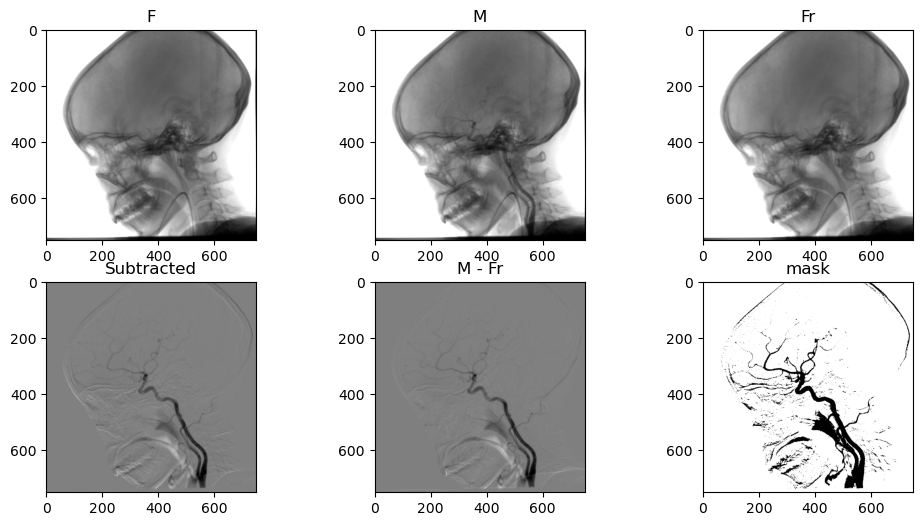

In [190]:
pred, _ = test(model, source, target)
show(source, target, pred)

In [108]:
import pyelastix
import matplotlib.pyplot as plt

# 读取固定图像和移动图像
im1 = cv2.imread(os.path.join('../data/F_skull', 'm100001.jpg'))
im2 = cv2.imread(os.path.join('../data/M_skull', 'm100001.jpg'))

# 选择一个通道，转为浮点型
im1 = im1[:, :, 0].astype('float32')
im2 = im2[:, :, 0].astype('float32')

# 获取默认参数值并设置一些参数
params = pyelastix.get_default_params(type='affine')
params.number_of_resolutions = 3

# 开始配准
im3, field = pyelastix.register(im1, im2, params)

Calling Elastix to register images ...
resolution 0, iter 1
resolution 0, iter 2
resolution 0, iter 3
resolution 0, iter 4
resolution 0, iter 5
resolution 0, iter 6
resolution 0, iter 7
resolution 0, iter 8
resolution 0, iter 9
resolution 0, iter 10
resolution 0, iter 11
resolution 0, iter 12
resolution 0, iter 13
resolution 0, iter 14
resolution 0, iter 15
resolution 0, iter 16
resolution 0, iter 17
resolution 0, iter 18
resolution 0, iter 19
resolution 0, iter 20
resolution 0, iter 21
resolution 0, iter 22
resolution 0, iter 23
resolution 0, iter 24
resolution 0, iter 25
resolution 0, iter 26
resolution 0, iter 27
resolution 0, iter 28
resolution 0, iter 29
resolution 0, iter 30
resolution 0, iter 31
resolution 0, iter 32
resolution 0, iter 33
resolution 0, iter 34
resolution 0, iter 35
resolution 0, iter 36
resolution 0, iter 37
resolution 0, iter 38
resolution 0, iter 39
resolution 0, iter 40
resolution 0, iter 41
resolution 0, iter 42
resolution 0, iter 43
resolution 0, iter 44
re

resolution 3, iter 441
resolution 3, iter 442
resolution 3, iter 443
resolution 3, iter 444
resolution 3, iter 445
resolution 3, iter 446
resolution 3, iter 447
resolution 3, iter 448
resolution 3, iter 449
resolution 3, iter 450
resolution 3, iter 451
resolution 3, iter 452
resolution 3, iter 453
resolution 3, iter 454
resolution 3, iter 455
resolution 3, iter 456
resolution 3, iter 457
resolution 3, iter 458
resolution 3, iter 459
resolution 3, iter 460
resolution 3, iter 461
resolution 3, iter 462
resolution 3, iter 463
resolution 3, iter 464
resolution 3, iter 465
resolution 3, iter 466
resolution 3, iter 467
resolution 3, iter 468
resolution 3, iter 469
resolution 3, iter 470
resolution 3, iter 471
resolution 3, iter 472
resolution 3, iter 473
resolution 3, iter 474
resolution 3, iter 475
resolution 3, iter 476
resolution 3, iter 477
resolution 3, iter 478
resolution 3, iter 479
resolution 3, iter 480
resolution 3, iter 481
resolution 3, iter 482
resolution 3, iter 483
resolution 

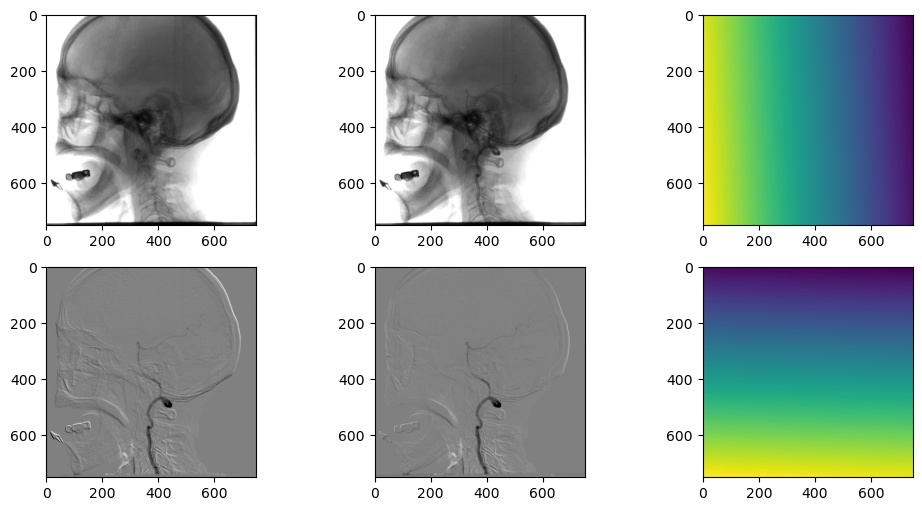

In [109]:
# 可视化结果
fig = plt.figure(figsize=(12, 6))
plt.clf()
plt.subplot(231); plt.imshow(im1, cmap='gray')
plt.subplot(232); plt.imshow(im2, cmap='gray')
plt.subplot(235); plt.imshow(im2 - im3, cmap='gray', vmin=-0.3 * 256, vmax=0.3 * 256)
plt.subplot(234); plt.imshow(im2 - im1, cmap='gray', vmin=-0.3 * 256, vmax=0.3 * 256)
plt.subplot(233); plt.imshow(field[0])
plt.subplot(236); plt.imshow(field[1])

# 保存结果
plt.savefig('filename.jpg')

KeyError: 'CUDA_LAUNCH_BLOCKING'